In [ ]:
import imageio as iio
import math

from skimage import filters
from skimage.color import rgb2gray
from skimage.measure import regionprops
from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert
from skimage import feature
from skimage.filters import gaussian
from skimage.segmentation import active_contour

import skimage

from ezdxf.addons.drawing.properties import LayoutProperties
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend

from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import ezdxf

from numba import jit
import timeit

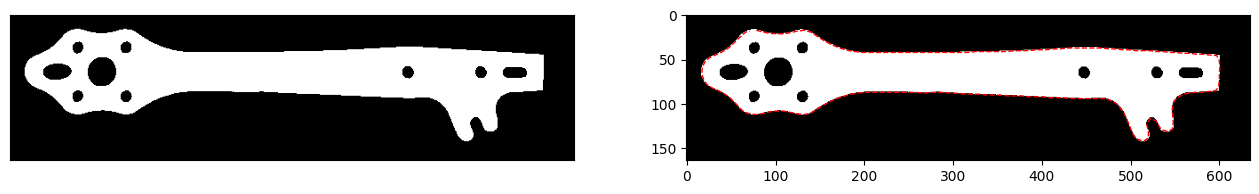

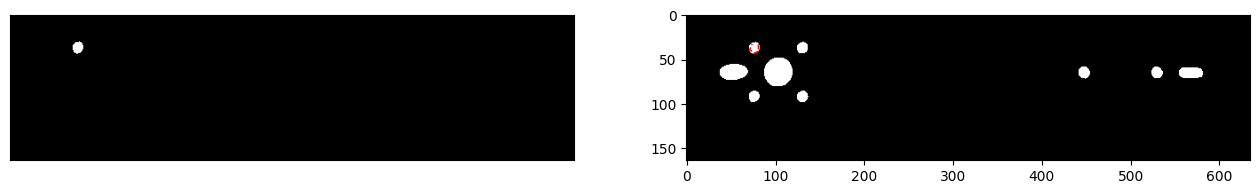

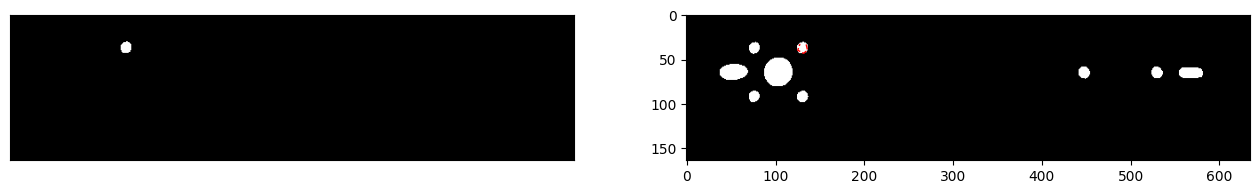

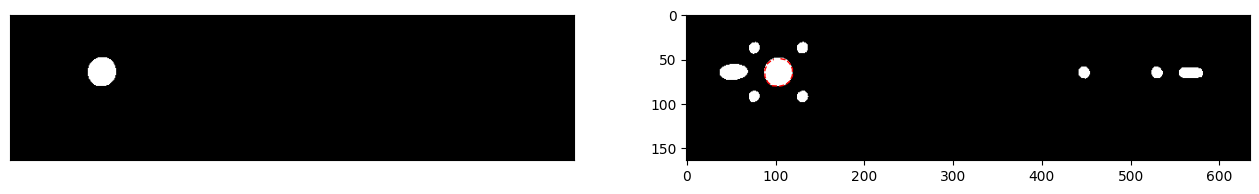

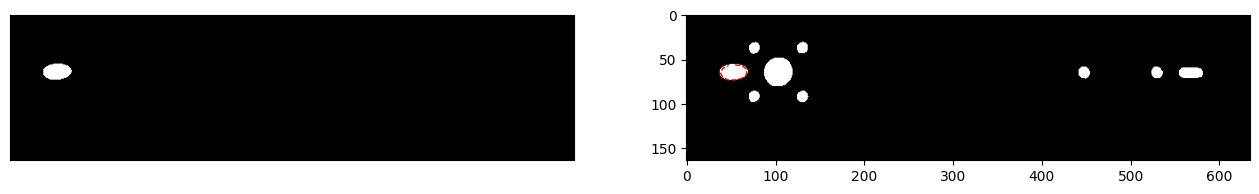

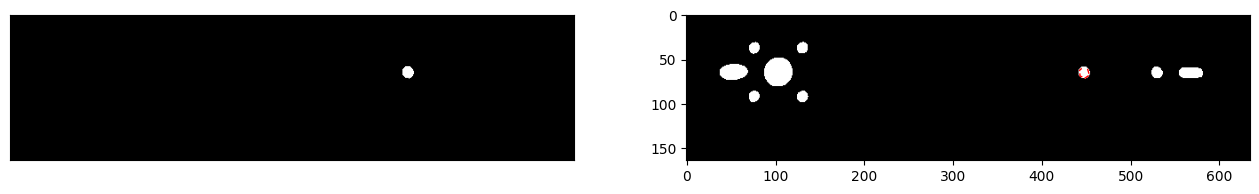

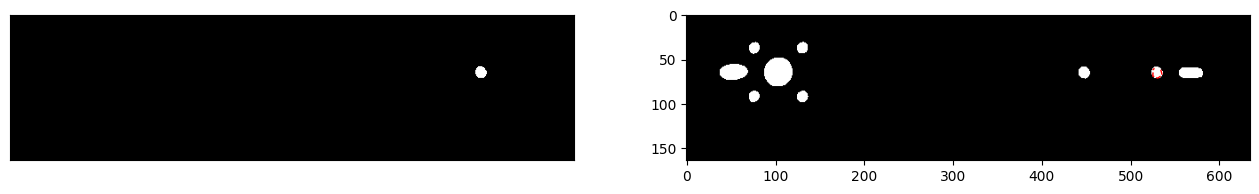

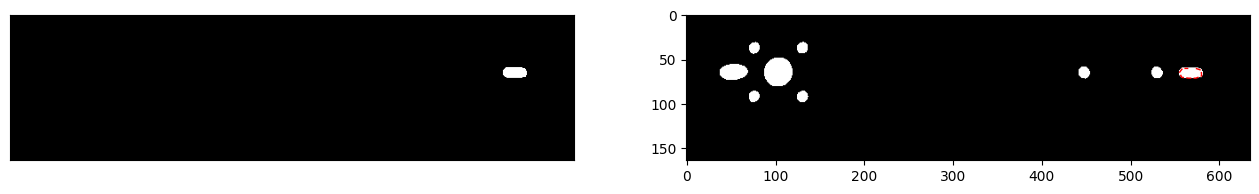

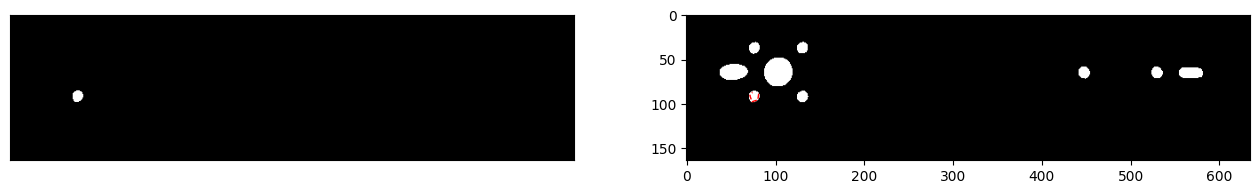

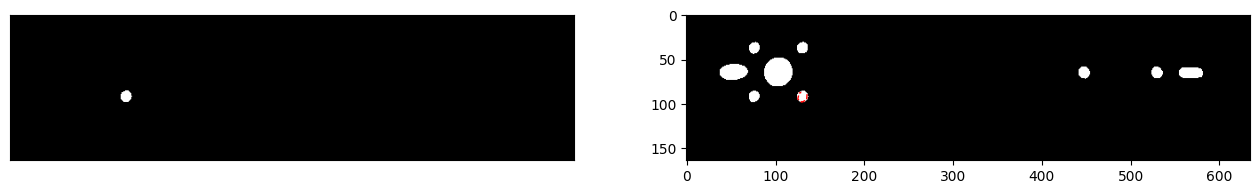

Done REC
time:  2.4218113338574767


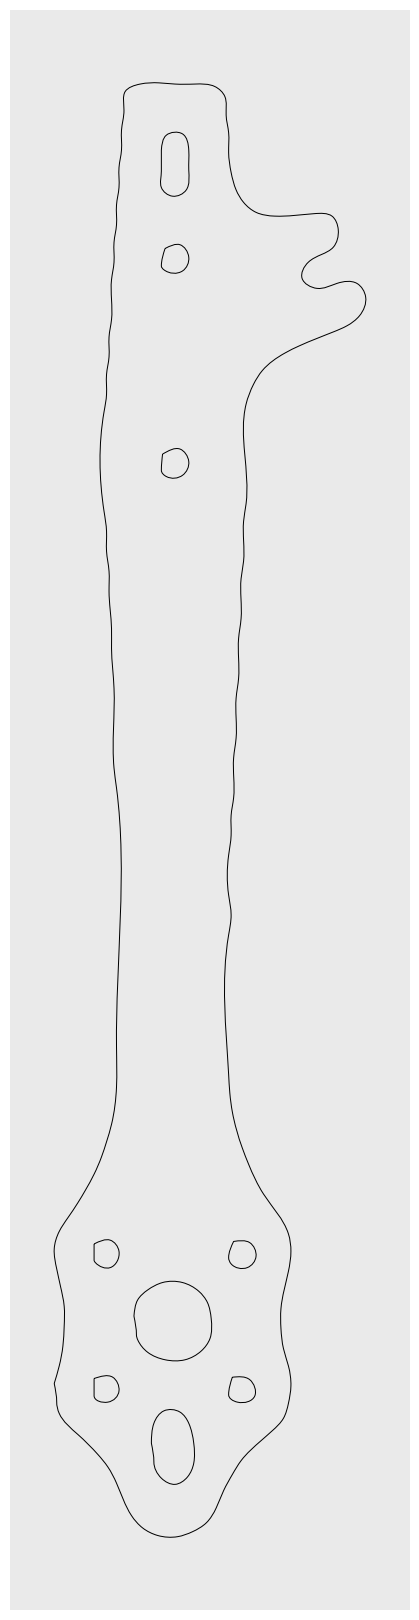

In [17]:
def regressive_polyimg_to_dxf_multi_spline(img, msp, s_foreground_thresh=160, refinements_chk=5, angle_reducer=0, distance_reducer=0, gaussian_sigma=3, preview=False, pass_bool=None, dppi=1):
    def reduce_polygon(polygon, angle_th=0, distance_th=0):
        angle_th_rad = np.deg2rad(angle_th)
        points_removed = [0]
        
        while len(points_removed):
            points_removed = list()
            
            for i in range(0, len(polygon)-2, 2):
                v01 = polygon[i-1] - polygon[i]
                v12 = polygon[i] - polygon[i+1]
                d01 = np.linalg.norm(v01)
                d12 = np.linalg.norm(v12)
                
                if d01 < distance_th and d12 < distance_th:
                    points_removed.append(i)
                    continue
                    
                angle = np.arccos(np.sum(v01*v12) / (d01 * d12))
                
                if angle < angle_th_rad:
                    points_removed.append(i)
            
            polygon = np.delete(polygon, points_removed, axis=0)
        
        return polygon
        
    def chaikins_corner(coords, refinements=5):
        coords = np.array(coords)
    
        for _ in range(refinements):
            L = coords.repeat(2, axis=0)
            R = np.empty_like(L)
            
            R[0] = L[0]
            R[2::2] = L[1:-1:2]
            R[1:-1:2] = L[2::2]
            R[-1] = L[-1]
            
            coords = L * 0.75 + R * 0.25
    
        return coords
    
    # start
    im_gray = np.array(img.convert('L'))
    im_gray_thresh = im_gray.copy()
    im_gray_thresh[im_gray_thresh < s_foreground_thresh] = 0
    im_bool = im_gray < s_foreground_thresh

    if pass_bool is not None:
        im_bool = pass_bool

    im_bin = im_bool.astype(np.uint8)

    labels, num = skimage.morphology.label(im_bin, background=None, return_num=True, connectivity=2)

    splinelst = []

    for l_num in range(1, num + 1):
        tr_arr = (labels == l_num) * 1.
        tr_bool = np.invert(ndimage.binary_fill_holes(labels == l_num))

        convimg = convex_hull_image(tr_arr)
        
        edges = feature.canny(tr_bool, sigma=gaussian_sigma)
        indices = np.where(edges == [1])
        
        # point sorting algorithm
        start_point = indices[1][0], indices[0][0]
        sorted_pts = []
        
        while len(start_point)>0:
            sorted_pts.append(start_point)
            x1, y1 = start_point
            dists = {(x2, y2): np.sqrt((x1-x2)**2 + (y1-y2)**2) for x2, y2 in zip(indices[1], indices[0])}
            dists = sorted(dists.items(), key=lambda item: item[1])
            
            for dist in dists:
                if dist[0] not in sorted_pts: 
                    start_point = dist[0]
                    break
                if dist == dists[-1]:
                    start_point = ()
                    break
                    
        pts_chaikin = chaikins_corner(sorted_pts, refinements=refinements_chk)
        pts_reduced = reduce_polygon(pts_chaikin, angle_th=angle_reducer, distance_th=distance_reducer)
                    
        pts_nd = np.array(pts_reduced)
        
        # move to next hull
        tr_inside = tr_arr.copy()
        tr_inside[tr_bool] = invert(tr_inside[tr_bool])
        tr_inside = invert(tr_inside)

        if preview:
            fig, ax = plt.subplots(1, 2, figsize=(16, 8))

            ax[1].imshow(im_bin, cmap=plt.cm.gray)
            ax[1].plot(pts_nd[:, 0], pts_nd[:, 1], '--r', lw=1)
            
            ax[0].imshow(tr_arr, cmap=plt.cm.gray)
            ax[0].set_xticks([]), ax[0].set_yticks([])
            ax[0].axis([0, im_gray_thresh.shape[1], im_gray_thresh.shape[0], 0])

            plt.show()

        fit_points = [(ptt[1]*dppi, ptt[0]*dppi, 0) for ptt in pts_nd] + [(pts_nd[0][1]*dppi, pts_nd[0][0]*dppi, 0)]
        splinelst.append(msp.add_spline(fit_points))

        regressive_polyimg_to_dxf_multi_spline(img, msp,
                                               s_foreground_thresh=s_foreground_thresh,
                                               gaussian_sigma=gaussian_sigma,
                                               refinements_chk=refinements_chk, 
                                               angle_reducer=angle_reducer, 
                                               distance_reducer=distance_reducer,
                                               preview=preview,
                                               pass_bool=tr_inside.astype(bool),
                                               dppi=dppi)

    return splinelst

# Test the function
def loaderDXF():
    demo_img = Image.open("demo1.jpg")
    
    doc = ezdxf.new("R2000")
    msp = doc.modelspace()
    
    splist = regressive_polyimg_to_dxf_multi_spline(demo_img, msp, 
                                                    s_foreground_thresh=160, 
                                                    gaussian_sigma=3,
                                                    refinements_chk=5, 
                                                    angle_reducer=2, 
                                                    distance_reducer=6,
                                                    preview=True)
    
    print("Done REC")
    
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 1, 1))
    
    ctx = RenderContext(doc)
    
    # get the modelspace properties
    msp_properties = LayoutProperties.from_layout(msp)
    
    # set light gray background color and black foreground color
    msp_properties.set_colors("#eaeaea")
    out = MatplotlibBackend(ax)
    
    # override the layout properties and render the modelspace
    Frontend(ctx, out).draw_layout(
        msp,
        finalize=True,
        layout_properties=msp_properties,
    )
    
    #fig.savefig("export.png")
    doc.saveas("chaikin10.dxf")

print("time: ", timeit.timeit(lambda: loaderDXF(), number=1))
